In this example we'll use scikit-learn and PySpark to predict and classify data in the the San Francisco dataset recently released from [Inside Airbnb](http://insideairbnb.com).  The data was released under the Creative Commons license and includes a sample of Airbnb listings from several global metropolitan areas.  

Each dataset released contains several items of interest, each in CSV format:
* ```listings.csv.gz``` - Detailed listings data, including various attributes (features) of each listing such as number of bedrooms, bathrooms, location, etc.
* ```calendar.csv.gz``` - Information about the availability calendar for each listing
* ```reviews.csv.gz``` - Individual reviews for listings
* neighborhoods and GeoJSON files - Mappings and detailed information for each neighborhood within a city

This example provides a good basis for exploring the capabilities of ```scikit-learn``` in Python and how we can use Apache Spark for cross-validation and tuning of hyperparameters to the various machine learning algorithms.



In the first example we will try to predict the listing price of the rental, using the columns in ```listings.csv``` as features.  We'll use the linear regression methods from scikit-learn, and then add Spark to improve the results and speed of an exhaustive search with ```GridSearchCV``` and an ensemble method (```GradientBoostingRegressor```).

First, let's load the ```listings.csv``` dataset from MapR-FS (conveniently and automatically mounted locally over NFS) into a Pandas dataframe.  The data consists of approximately 7000 listings with over 90 different columns, describing each listing in detail.  Not all of them are useful, so let's start by picking a few that look like obvious candidates for predicting the price.  

In [364]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter


LISTINGSFILE = '/mapr/tmclust1/user/mapr/pyspark-learn/airbnb/listings.csv'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols)

len(df.index)

7029

The ```neighborhood_cleansed``` field contains the neighborhood of the rental, which is one of San Francisco's 40 different distinct neighborhoods.  Not all of them are represented in the data equally -- if we look at the distribution below, we can see it follows a curve, with the Mission having the highest number of listings.  Overall we have a good spread of rows in different neighborhoods so this field looks like it could be useful.

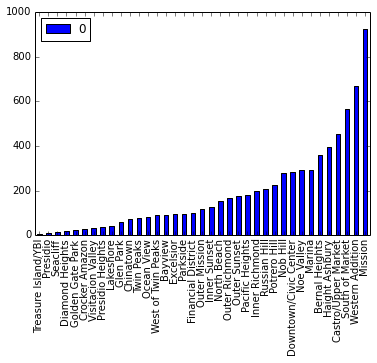

In [365]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

This data is coming in raw, so a little cleaning is in order.

Particularly, the ```number_reviews``` and ```reviews_per_month``` fields look like they need some special processing to remove a large number of NaN values.  Rather than discarding these outright, we set the value of ```reviews_per_month``` to 0 where there is a NaN, because it this field appears to be NaN whenever ```number_of_reviews``` is 0.  We also delete any entries with a value of 0 for bedrooms, beds, or price, then drop any remaining rows that have NaN values.

In [366]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == False)].index)

0

In [367]:
# the number of entries with at least 1 'number_of_reviews' which have a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [368]:
# so we need to do some cleaning.

# first fixup 'reviews_per_month' where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# just drop rows with bad/weird values
# (we could do more here)
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

5246

The last bit of cleaning/filtering we'll do is convert the 'price' column to floating point, and drop all of the entries with more than one bedroom.

As we see below, 70% of the entries in this file are for one bedroom listings (in large cities, especially San Francisco, this might be the norm), so it's the type of unit for which we have the most samples.  This focus on a single type of unit will also make our model better because there is less to discover about the complex interactions with other features (such as whether the unit is shared, private, or has a private room).  To make predictions for larger units, one way to go would be to develop separate models for each of the different sizes (2, 3, 4 bedrooms, etc.), or do some clustering to see if it is better to partition the data in some other way.

In [369]:
df = df[df.bedrooms == 1]
len(df.index)

3821

In [370]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

0    350.0
2    119.0
5     80.0
7    215.0
9    224.0
Name: price, dtype: float64

We have a few columns that contain categorical variables.  These are handled in slightly different ways.

The ```neighborhood_cleansed``` field, in its raw form, is a string representing the name of the neighborhood.  The linear models will only accept numeric fields, we use the ```get_dummies``` routine in Pandas to convert these to 'dummy' variables.  This is also known as "one hot" encoding, and means that we add a column for every possible value of the field.  Each listing (row) contains a '1' in for its own neighborhood, else the column contains a '0' for that neighborhood.  We handle this in a similar way for the ```room_type``` and ```cancellation_policy``` fields.

For the ```instant_bookable``` field, we can represent it with a single column since it's a boolean value (it represents whether or not the unit can be booked instantly online without confirmation from the owner).

In [371]:
# get feature encoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# convert boolean column to a single boolean value indicating whether this listing has instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# replace the old columns with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Bayview,Bernal Heights,...,Western Addition,Entire home/apt,Private room,Shared room,flexible,moderate,strict,super_strict_30,super_strict_60,instant_t
0,2,1.0,1.0,350.0,30,8,89.0,0.28,0,0,...,0,1,0,0,0,0,1,0,0,0
2,2,1.0,1.0,119.0,15,10,92.0,2.33,0,0,...,0,0,1,0,0,0,1,0,0,0
5,2,1.0,1.0,80.0,20,24,94.0,1.13,0,0,...,0,0,1,0,0,1,0,0,0,0
7,3,1.0,1.0,215.0,0,1,100.0,0.18,0,0,...,0,1,0,0,0,1,0,0,0,0
9,4,1.0,3.0,224.0,0,57,97.0,3.94,0,0,...,0,1,0,0,0,0,1,0,0,0


Using the ```scatter_matrix``` function in Pandas next, we can quickly show a matrix of each feature as a function of another, checking for any collinearity among the features.  The diagonal of this matrix is a histogram of the features along the X axis.  Collinearity is less likely because we've picked a small set of features that are not obviously related to each other, but it's a good thing to check to see if we have anything that will throw off our model.

Looking at the output of ```scatter_matrix```, no features show any obvious problems (we're looking for straight lines).  The most closely related features in this matrix appear to be ```beds``` and ```accommodates```, which makes sense.  The more beds a unit has, the more it accommodates for sleeping, but even these are only loosely related.  Presumably this is because of different bed sizes and possible sleeping arrangements.

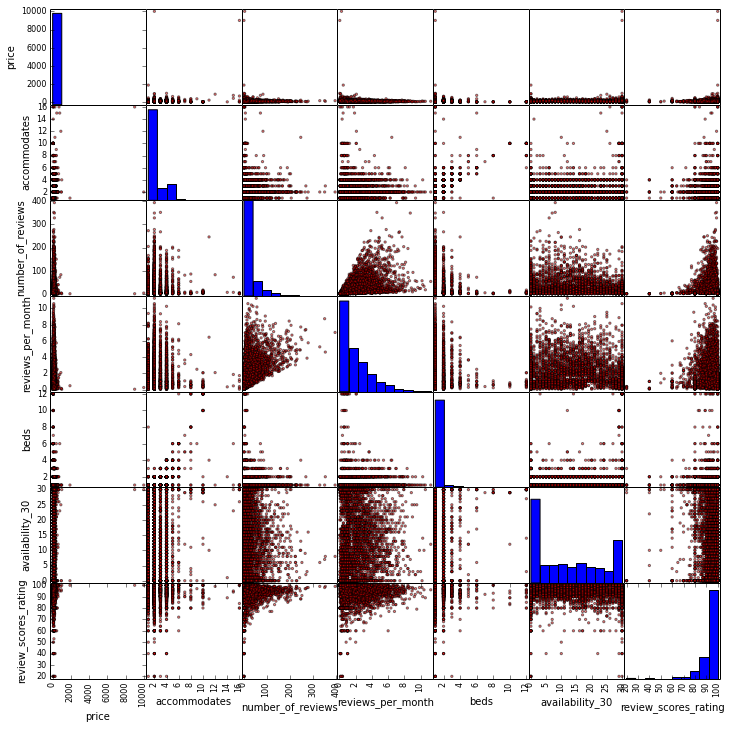

In [372]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

One of the great things about scikit-learn is that we can easily try a bunch of different linear models (or classifiers) on the same data.  This will give us some clues as to where we can start tuning or which models may be a good choice.   We'll try the five models below:  vanilla linear regression, Ridge and Lasso regressions, ElasticNet, Perceptron, and a lesser used one called OrthogonalMatchingPursuit.

We need some way to score the results.  In this example I've chosen median absolute error, mainly because it makes sense on the surface (it easily translates to a dollar amount relative to price) and is less sensitive to outliers than other metrics like mean squared error.  It's likely that we have some outliers in the data since we haven't done any filtering or clustering for them, so this is a good way to get a quick and dirty measure of performance before we move to fine-tuning.

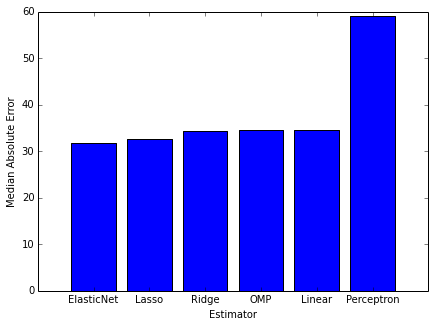

In [378]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.Perceptron(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'Perceptron', 'OMP'])
errvals = np.array([])
for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

It looks like they're about the same except for the Perceptron model, which is not surprising because we haven't done any tuning.  This gives us a good general idea of where we stand with the individual regression methods in scikit-learn.

Next we'll try an ensemble method to see if we can get better results.  The ensemble methods have a large variety of hyperparameters that can be tuned, each of which can affect our model and require some experimentation to get right.  The common way to approach this is to use an exhaustive "grid search" which simply tries all the supplied parameter combinations.  Scikit-learn provides the very handy ```GridSearchCV``` function for this purpose, which also includes cross validation as way to score each iteration that it tries.  

For our first attempt, we'll limit the number of parameters just so we can get the results back quickly and see if we're doing better than any of the individual methods above.

In [379]:
n_est = 300
tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.01,
             loss='lad', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [381]:
abs(clf.best_score_)

23.575442102105878

It looks like we're doing better with ```GradientBoostingRegressor```.  Without doing any tuning, the median error is quite a bit less than the best error of the previous group.

Let's get a quick measure of how the error is affected by each round of boosting, so we can see if throwing more iterations at the problem is going to help.

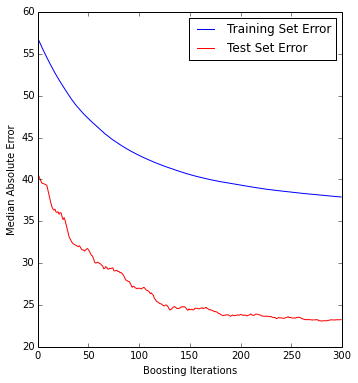

In [382]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = metrics.median_absolute_error(y_true, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), best.train_score_, 'b-', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'r-', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Median Absolute Error')

It looks like the curve is flattening near the right side of the plot (after around 100-150 iterations), but is still benefitting from more iterations.

Now we can do some tuning with ```GridSearchCV``` and explore more of the hyperparameter combinations.  However, this requires CPU and a complete run of all of the combinations can easily take hours of wall-clock time to finish.

By simply replacing the following lines in our file, we can use the new [spark-sklearn](http://spark-packages.org/package/databricks/spark-sklearn) from [DataBricks](https://databricks.com/blog/2016/02/08/auto-scaling-scikit-learn-with-spark.html), running on the [MapR 5.1](https://www.mapr.com/why-hadoop/why-mapr/enterprise-platform) platform as a YARN client to distribute the iterations across the machines in a cluster.  This allows us to test more hyperparameter combinations which ultimately gives us less error, and we can do it in less time.  

```
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV

conf = SparkConf()
sc = SparkContext(conf=conf)
clf = GridSearchCV(sc, gbr, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')
```

The architecture of this approach is different than that used by MLlib in Spark.  Using ```spark-sklearn```, we're simply distributing the cross-validation run of each model (with a specific combination of hyperparameters) across each Spark executor.  Spark MLlib, on the other hand, will distribute the actual learning algorithms across the cluster.  The main advantage of ```spark-sklearn``` is that it enables leveraging the very rich set of machine learning algorithms in scikit-learn.  These algorithms do not run natively on a cluster (although they can be parallelized on a single machine) and by bringing Spark to the party, ```spark-sklearn``` can unlock more computing resources than could ordinarily be used. 

Using this approach we can get the error down even further, to 21.43.

[insert graph on time reduction with spark_sklearn)


Finally let's look at the feature importances to see which features were most influential in predicting the listing price.

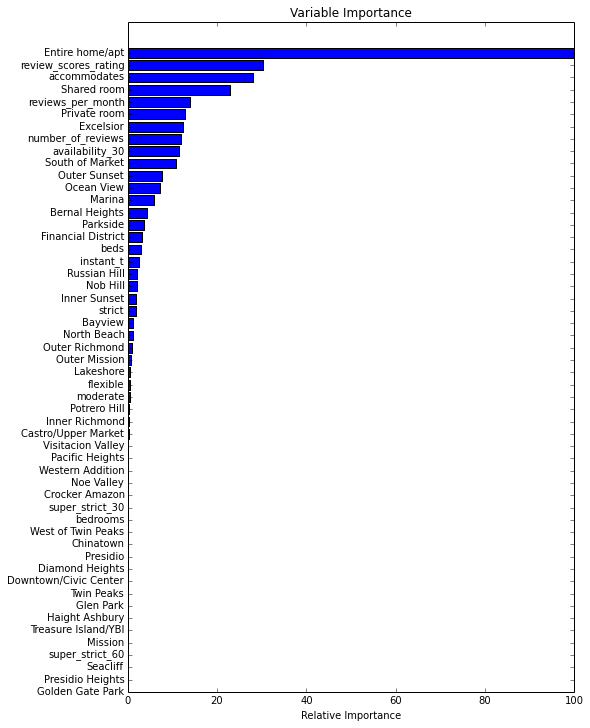

In [383]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

In this example we looked at how to predict the price using multiple factors, then scale-out our cross validation and hyperparameter search across a MapR cluster.  This is a straightforward way to throw more horsepower at any machine learning problem you might have.

In the next post in the series we'll look at how to to this with classifiers. 